# Ordinals Financial Analysis
Eben Maré

30 January 2025

## Introduction
In what follows we perform statistical and financial analysis on Bitcoin Ordinal prices (and returns). We wish to look at return distributions, correlation with BTC, etc. in order to draw conclusions that might be helpful in assessing the value of ordinal collections.

The ordinals market is still relatively new, and not that well developed. There are a couple of marketplaces, of which Magic Eden is the biggest. There is limited data on bid prices, and instead collections have a floor prices (the lowest price at which an ordinal holder is willing to sell). In a regular market we would consider mid prices (the midpoint between the bid and ask price), but this is not readily available for ordinals. We have thus opted to use traded prices for the most liquid collections in Magic Eden. We think prices at which trades were executed are a better reflection of the market.


## Environment and Data

First off, load the packages that we will be using in this notebook.

In [26]:
# import all packages that will be used in the notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

We have sourced all the traded prices we could find (limited to 2100 trades per collection, by the API) for the five most liquid collections as at 30 January 2025. We also use Bitcoin price data. The data is available in the *data* folder. The collections are as follows (the names in parentheses will be used throughout, and these correspond to the collection Id's in Magic Eden):
- Bitcoin Puppets (bitcoin-puppets, https://magiceden.io/ordinals/marketplace/bitcoin-puppets)
- Quantum Cats (quantum_cats, https://magiceden.io/ordinals/marketplace/quantum_cats)
- NodeMonkes (nodemonkes, https://magiceden.io/ordinals/marketplace/nodemonkes)
- Ordinal Maxi Biz (omb, https://magiceden.io/ordinals/marketplace/omb)
- Runestone (runestone, https://magiceden.io/ordinals/marketplace/runestone).

We load the data into dataframes (via pandas), which make various types of analysis easy, and then merge the data into a single dataframe for further consumption.

In [27]:
# Load ordinal collection data and preprocess it
# This data contains the top NFT collection price history
collections_df = pd.read_csv('./data/top_collection_price_history.csv',
                             usecols=['collection', 'date', 'price'],
                             parse_dates=['date'])  # Automatically parse 'date' columns as datetime
collections_df = collections_df.rename(columns={'price': 'collection_price'})  # Rename 'price' column for clarity
collections_df = collections_df.sort_values(by='date', ascending=True)  # Sort the data by 'date' in ascending order
collections_df['date'] = pd.to_datetime(collections_df['date'])  # Ensure 'date' column is in datetime format
collections_df['date'] = collections_df['date'].dt.tz_localize(None)  # Remove timezone information

# Load Bitcoin price data and preprocess it
# This dataset contains Bitcoin's daily closing prices
btc_df = pd.read_csv('./data/btc_price_data.csv',
                     usecols=['date', 'close'],
                     parse_dates=['date'],
                     dtype={'close': 'float64'},
                     date_format='%d-%b-%y')  # Specify date format for parsing
btc_df = btc_df.rename(columns={'close': 'btc_price'})  # Rename 'close' column for clarity
btc_df = btc_df.sort_values(by='date', ascending=True)  # Sort the data by 'date' in ascending order
btc_df['date'] = pd.to_datetime(btc_df['date'])  # Ensure 'date' column is in datetime format
btc_df['date'] = btc_df['date'].dt.tz_localize(None)  # Remove timezone information
btc_df['date'] = btc_df['date'].dt.date  # Convert datetime to date for consistency in merging
btc_df.set_index('date', inplace=True)  # Set 'date' as the index for easier mapping

# Convert the Bitcoin DataFrame to a dictionary for fast lookups during mapping
df_dict = btc_df.to_dict(orient='dict')  # Convert to a nested dictionary with 'btc_price' as a top-level key

# Add 'btc_price' to the collections_df DataFrame by mapping 'btc_price' based on the 'date'
# Here, we use a lambda function to handle missing keys safely with the dictionary's get() method
collections_df['btc_price'] = collections_df['date'].map(
    lambda x: df_dict['btc_price'].get(x.date())
)

Next, we plot all the prices (that we have in our data) over time.

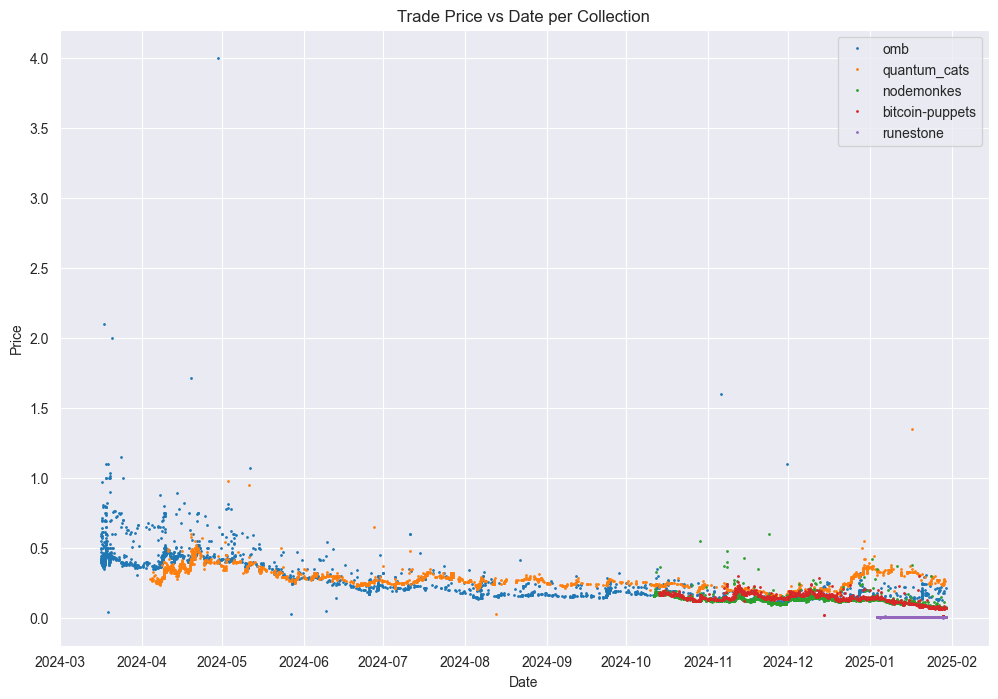

In [28]:
# Plot the traded prices for the collections
# This cell creates a visualization that shows the traded price of each NFT collection over time.

# Get a list of unique NFT collections from the 'collections_df' DataFrame
collections = collections_df['collection'].unique()

# Create a new figure with the specified size for the plot
plt.figure(figsize=(12, 8))

# Iterate over each unique NFT collection
for collection in collections:
    # Filter the DataFrame to include only the rows relevant to the current collection
    collection_data = collections_df[collections_df['collection'] == collection]

    # Plot the collection's traded price against the date
    # Each collection's prices are represented as a scatter plot with small circular markers
    plt.plot(
        collection_data['date'],
        collection_data['collection_price'],
        label=collection,
        marker='o',
        linestyle='',  # No line between points
        markersize=1  # Small marker size
    )

# Label the x-axis as "Date"
plt.xlabel('Date')

# Label the y-axis as "Price"
plt.ylabel('Price')

# Add a title to the plot
plt.title('Trade Price vs Date per Collection')

# Add a legend to the plot to identify each collection by its name
plt.legend()

# Add a grid to the plot for better readability of data points
plt.grid(True)

# Display the plot
plt.show()

From the above we can see that there are some outliers - these could be due to rare asset purchases, or other factors. For this analysis, we are interested in an market "price" of the collection (there is no single price, only prices for each of the assets). To this end, trades that are executed at prices significantly different to other trades at the same time, are considered outliers, and we're going to look at median prices over a suitable rolling window period (e.g., every 3-days).

You are welcome to change the *resample_period* variable below, e.g., to 2D for two-days, to look at the impact of this.

<Figure size 1200x800 with 0 Axes>

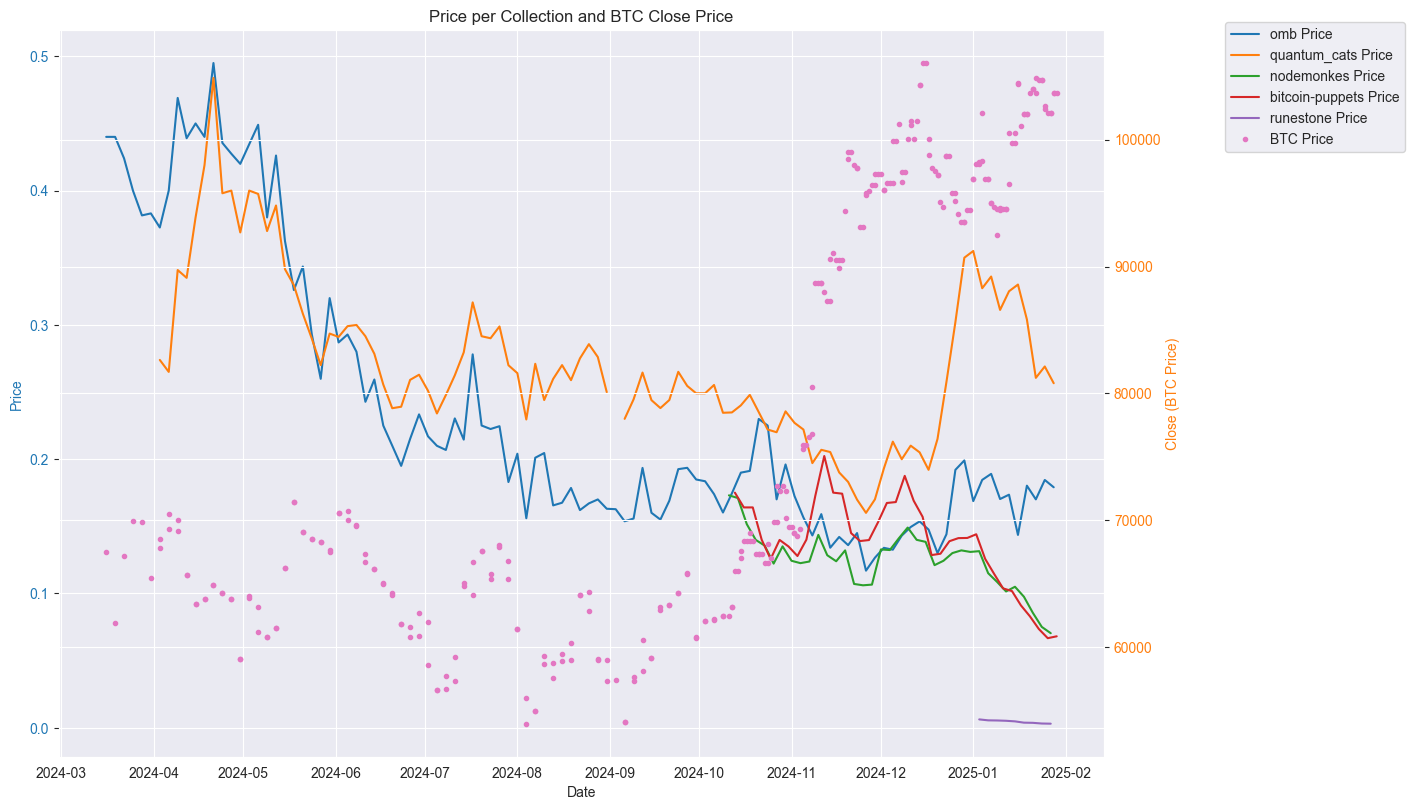

In [29]:
# Set the resampling period to 3 days
resample_period = '3D'

# Resample the collections DataFrame to compute median prices over the specified time intervals
resampled_df = (
    collections_df
    .set_index(['date', 'collection'])  # Temporarily set 'date' and 'collection' as the index for easier resampling
    .groupby('collection')  # Group the data by 'collection' to ensure each collection is treated individually
    .resample(resample_period, level='date')  # Resample based on 'date' using the defined time interval
    .median()  # Compute the median values for each group
    .reset_index()  # Reset the index back to a standard DataFrame format
)

# Calculate the Bitcoin log returns:
# Transform each collection's Bitcoin prices to compute log returns (natural log price changes)
resampled_df['btc_log_return'] = resampled_df.groupby('collection')['btc_price']\
    .transform(lambda x: np.log(x / x.shift(1)))

# Calculate the collection log returns:
# Transform each collection's traded prices to compute their log returns
resampled_df['collection_log_return'] = resampled_df.groupby('collection')['collection_price']\
    .transform(lambda x: np.log(x / x.shift(1)))

# Calculate the traded price of each collection in USD:
# Multiply the collection's price in BTC by the corresponding BTC-to-USD price
resampled_df['collection_usd_price'] = resampled_df['collection_price'] * resampled_df['btc_price']

# Create a plot to compare collection prices over time and Bitcoin prices
plt.figure(figsize=(12, 8))  # Set the figure size for better readability
fig, ax1 = plt.subplots(figsize=(12, 8))    # Create a plot with two y-axes for visualization

# Configure the first y-axis (collection prices)
ax1.set_xlabel('Date')  # Label the x-axis as "Date"
ax1.set_ylabel('Price', color='tab:blue')  # Label the y-axis for collection prices

# Plot the collection price for each NFT collection
for collection in collections:
    # Filter the DataFrame for the current collection
    data = resampled_df[resampled_df['collection'] == collection]
    # Plot collection price against date with a line plot
    ax1.plot(data['date'], data['collection_price'], label=f'{collection} Price', linestyle='-', marker=None)

# Set the tick parameters and color for the y-axis
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Configure the secondary y-axis (Bitcoin prices)
ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
ax2.set_ylabel('Close (BTC Price)', color='tab:orange')  # Label the secondary y-axis for Bitcoin prices

# Plot Bitcoin prices against dates
ax2.plot(
    resampled_df['date'], resampled_df['btc_price'],
    label='BTC Price', color='tab:pink', linestyle='', marker='.'
)

# Set the tick parameters and color for the secondary y-axis
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Adjust the layout to make the plot elements fit neatly
fig.tight_layout()

# Add a legend for the figure
fig.legend(loc='upper center', bbox_to_anchor=(1.1, 1.0))

# Add grid lines for ease of reading the plots
plt.grid(True)

# Set the title for the plot
plt.title('Price per Collection and BTC Close Price')

# Display the final plot
plt.show()

From the above we have concluded that using the median price over a 3-day period is sufficient to get rid of outliers.

We can also see that we don't have data for all the collections over the entire history, so we are going to filter to the last couple of months. You can change *num_months_to_use* below, to include more or less data, and the collections for which there are missing data will simply be excluded.

In [30]:
# Number of months to filter the data for analysis
num_months_to_use = 3

# Get the latest date in the resampled DataFrame
latest_date = resampled_df['date'].max()

# Calculate the start date by subtracting the specified number of months from the latest date
start_date = latest_date - pd.DateOffset(months=num_months_to_use)

# Determine the earliest date for each collection in the dataset
first_date_per_collection = resampled_df.groupby('collection')['date'].min()

# Identify collections that do not have data starting from or before the calculated start date
excluded_collections = first_date_per_collection[first_date_per_collection >= start_date].index.unique()

# If any collections are excluded, print a warning message with their names
if len(excluded_collections) > 0:
    print(f"Warning: The following collections don't have complete data to the start date {start_date} and will be excluded: {list(excluded_collections)}")

# Filter the analysis DataFrame to include only:
# - Rows where the 'date' is on or after the calculated start date
# - Collections that are not in the excluded list
resampled_df = resampled_df[(resampled_df['date'] >= start_date) &
                            (~resampled_df['collection'].isin(excluded_collections))]

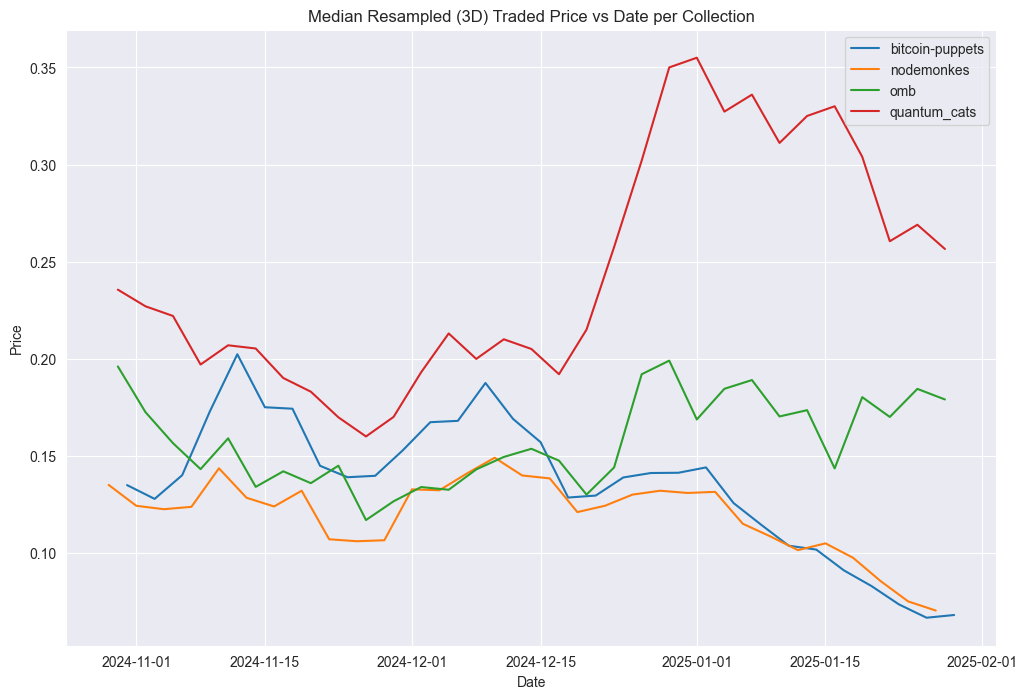

In [31]:
# Get the unique NFT collections from the cleaned and filtered dataset
collections = resampled_df['collection'].unique()

# Create a new figure for the plot with the specified size
plt.figure(figsize=(12, 8))

# Loop through each unique NFT collection
for collection in collections:
    # Filter the DataFrame to include only the rows relevant to the current collection
    collection_data = resampled_df[resampled_df['collection'] == collection]

    # Plot the collection's median resampled traded price over time
    plt.plot(
        collection_data['date'],                # The x-axis (dates)
        collection_data['collection_price'],    # The y-axis (collection prices)
        label=collection                        # Label for the legend
    )

# Add a label to the x-axis
plt.xlabel('Date')

# Add a label to the y-axis
plt.ylabel('Price')

# Add a title to the plot, dynamically including the resample period in the title
plt.title('Median Resampled ({}) Traded Price vs Date per Collection'.format(resample_period))

# Display the legend to identify each collection by its label
plt.legend()

# Enable grid lines for better readability of the chart
plt.grid(True)

# Display the resulting plot
plt.show()

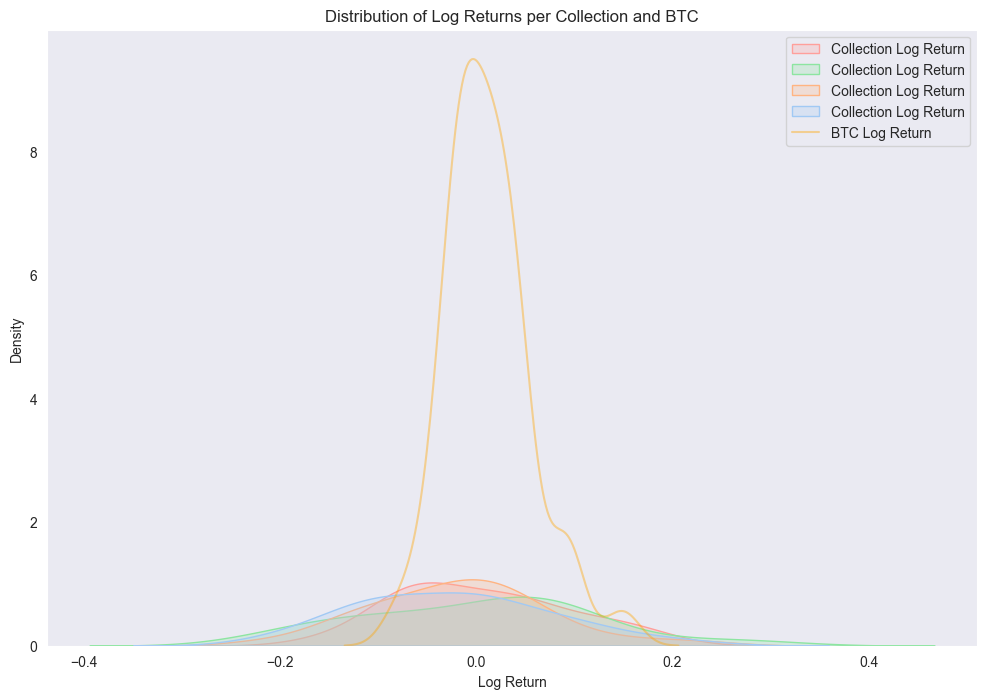

In [32]:
# Set the figure size for the plot
plt.figure(figsize=(12, 8))

# Plot the Kernel Density Estimate (KDE) for 'collection_log_return'
# - Filter out rows where 'collection_log_return' is NaN
# - Plot density for each collection, using pastel colors and filling the area under the curve
sns.kdeplot(
    data=resampled_df.dropna(subset=['collection_log_return']),  # Drop rows with missing collection_log_return
    x='collection_log_return',  # Log return of collections
    hue='collection',           # Differentiate by collection
    palette='pastel',           # Use pastel colors for the plot
    fill=True,                  # Fill the area under the density curve
    label='Collection Log Return'
)

# Plot the KDE for 'btc_log_return'
# - Filter out rows where 'btc_log_return' is NaN
# - Use orange color, without filling, and with some transparency
sns.kdeplot(
    data=resampled_df.dropna(subset=['btc_log_return']),  # Drop rows with missing btc_log_return
    x='btc_log_return',         # Log return of Bitcoin
    color='orange',             # Use orange color
    fill=False,                 # Do not fill the area under the curve
    alpha=0.4,                  # Set transparency for better visualization
    label='BTC Log Return'      # Add a label for Bitcoin log return
)

# Set the x-axis label to 'Log Return'
plt.xlabel('Log Return')

# Set the y-axis label to 'Density'
plt.ylabel('Density')

# Set the title of the plot to 'Distribution of Log Returns per Collection and BTC'
plt.title('Distribution of Log Returns per Collection and BTC')

# Display the legend to identify the KDE plots
plt.legend()

# Add gridlines to the plot for improved readability
plt.grid()

# Show the resulting plot
plt.show()

Let's create an index for ordinal prices. We will do this by equally weighting each of the returns, and since the returns are log returns, we can simply sum them. We then create an index starting at 100.0, and growing it by the new index log return each day.

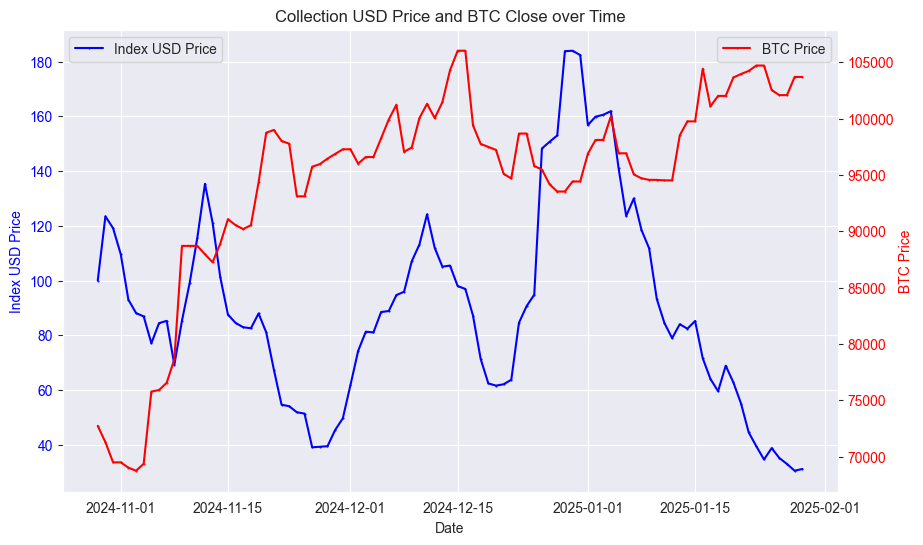

In [49]:
# Transform 'resampled_df' by computing:
# - The average of 'collection_price' across collections for each day
# - The sum of 'collection_log_return' across collections for each day

# Group by 'date' to perform the aggregation
index_df = resampled_df.copy().groupby('date').agg({
    'collection_log_return': 'sum',       # Sum of collection log returns across collections,
    'btc_price': 'mean',                  # BTC price will remain the same by averaging the same value each day
    'btc_log_return': 'mean',             # BTC log return will remain the same by averaging the same value each day
}).reset_index()  # Reset the index to keep 'date' as a column
index_df.rename(columns={'collection_log_return': 'index_log_return'}, inplace=True)

# Calculate `index_price`, which starts at 100 and updates daily with exp(index_return)
index_df['index_usd_price'] = 100.0  # Initialize the first value to 100
for i in range(1, len(index_df)):
    index_df.loc[i, 'index_usd_price'] = index_df.loc[i - 1, 'index_usd_price'] * np.exp(index_df.loc[i, 'index_log_return'])

# Create a new figure with the specified size for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the USD price trend for the specified collection over time on the primary y-axis
ax1.plot(
    index_df['date'],  # X-axis: Date
    index_df['index_usd_price'],  # Y-axis: Index USD Price
    marker='.',  # Use dot markers for data points
    linestyle='-',  # Use a solid line to connect the points
    markersize=1,  # Set the marker size to 1 for a clean plot
    label='Index USD Price',  # Label for the plot legend
    color='blue'
)

# Set the x-axis and y-axis labels for the primary axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Index USD Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot BTC price
ax2 = ax1.twinx()
ax2.plot(
    index_df['date'],  # X-axis: Date
    index_df['btc_price'],  # Y-axis: BTC Price
    marker='.',  # Use dot markers for data points
    linestyle='-',  # Use a solid line to connect the points
    markersize=1,  # Set the marker size to 1 for a clean plot
    color='red',  # Use red color for this plot
    label='BTC Price'
)

# Set the y-axis label for the secondary axis
ax2.set_ylabel('BTC Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title of the plot
plt.title('Collection USD Price and BTC Close over Time')

# Add grid lines to the plot for readability
plt.grid()

# Add a combined legend for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the resulting plot
plt.show()

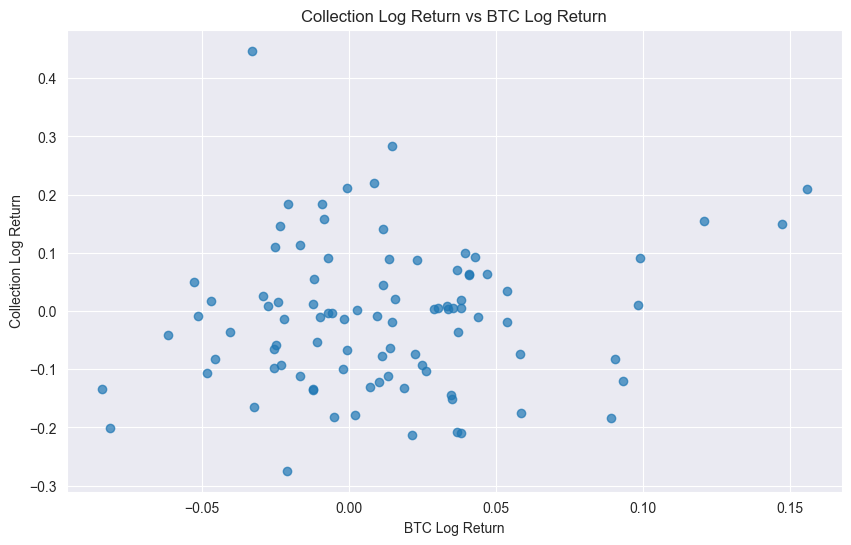

In [50]:
# Create a figure with the specified size for the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot to visualize the relationship between Bitcoin's log return and the NFT collection's log return
# - Filter the data to only include rows where 'collection' matches the specified collection
# - Use 'btc_log_return' for the x-axis and 'collection_log_return' for the y-axis
# - Set the transparency of the points to 0.7 for better visualization
plt.scatter(
    index_df['btc_log_return'],  # X-axis: BTC log return
    index_df['index_log_return'],  # Y-axis: Collection log return
    alpha=0.7  # Set transparency for the scatter points
)

# Label the x-axis as "BTC Log Return"
plt.xlabel('BTC Log Return')

# Label the y-axis as "Collection Log Return"
plt.ylabel('Collection Log Return')

# Add a title to the plot to describe the visualization purpose
plt.title('Collection Log Return vs BTC Log Return')

# Add grid lines to the plot for better readability of the points
plt.grid(True)

# Display the scatter plot
plt.show()